In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchinfo import summary

# ---------------------------
# Seed
# ---------------------------
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything()




# ---------------------------
# Model blocks
# ---------------------------
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.fc1 = nn.Linear(in_channels, in_channels // reduction)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels)

    def forward(self, x):
        b, c, _, _ = x.size()
        y = F.adaptive_avg_pool2d(x, 1).view(b, c)
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).view(b, c, 1, 1)
        return x * y

class Res2Block(nn.Module):
    def __init__(self, channels, scale=4):
        super().__init__()
        self.scale = scale
        self.width = channels // scale
        self.conv_first = nn.Conv2d(channels, channels, kernel_size=1)
        self.convs = nn.ModuleList([nn.Sequential(
            nn.Conv2d(self.width, self.width, 3, padding=1),
            nn.BatchNorm2d(self.width, momentum=0.002),
            nn.ReLU(inplace=True)
        ) for _ in range(scale - 1)])
        self.conv_last = nn.Conv2d(channels, channels, kernel_size=1)
        self.bn_last = nn.BatchNorm2d(channels, momentum=0.002)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.conv_first(x)
        splits = torch.split(out, self.width, dim=1)
        outputs = [splits[0]]
        for i in range(1, self.scale):
            if i == 1:
                sp = splits[i]
            else:
                sp = splits[i] + outputs[i - 1]
            outputs.append(self.convs[i - 1](sp))
        out = torch.cat(outputs, dim=1)
        out = self.conv_last(out)
        out = self.bn_last(out)
        return self.relu(out)

class Res2SEBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.res2 = Res2Block(channels)
        self.se = SEBlock(channels)

    def forward(self, x):
        x = self.res2(x)
        x = self.se(x)
        return x

class PDCBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branch1 = nn.Conv2d(in_channels, out_channels, 3, padding=1, dilation=1)
        self.branch2 = nn.Conv2d(in_channels, out_channels, 3, padding=2, dilation=2)
        self.branch3 = nn.Conv2d(in_channels, out_channels, 3, padding=3, dilation=3)
        self.branch4 = nn.Conv2d(in_channels, out_channels, 3, padding=4, dilation=4)
        self.fuse = nn.Conv2d(out_channels * 4, out_channels, 1)

    def forward(self, x):
        b1 = self.branch1(x)
        b2 = self.branch2(x)
        b3 = self.branch3(x)
        b4 = self.branch4(x)
        out = torch.cat([b1, b2, b3, b4], dim=1)
        return self.fuse(out)

class MIFModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 1)
        self.conv2 = nn.Conv2d(3, 128, 1)
        self.conv3 = nn.Conv2d(3, 256, 1)
        self.conv4 = nn.Conv2d(3, 512, 1)

    def forward(self, x):
        s1 = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=True)
        s2 = F.interpolate(x, size=(112, 112), mode='bilinear', align_corners=True)
        s3 = F.interpolate(x, size=(56, 56), mode='bilinear', align_corners=True)
        s4 = F.interpolate(x, size=(28, 28), mode='bilinear', align_corners=True)

        s1 = self.conv1(s1)
        s2 = self.conv2(s2)
        s3 = self.conv3(s3)
        s4 = self.conv4(s4)

        return s1, s2, s3, s4

class MRPUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.mif = MIFModule()

        self.enc1 = Res2SEBlock(64)
        self.enc2 = Res2SEBlock(128)
        self.enc3 = Res2SEBlock(256)
        self.enc4 = Res2SEBlock(512)

        self.proj2 = nn.Conv2d(64, 128, kernel_size=1)
        self.proj3 = nn.Conv2d(128, 256, kernel_size=1)
        self.proj4 = nn.Conv2d(256, 512, kernel_size=1)

        self.pool = nn.MaxPool2d(2)
        self.pdc = PDCBlock(512, 1024)

        self.up3 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec3 = Res2SEBlock(512)

        self.up2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec2 = Res2SEBlock(256)

        self.up1 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec1 = Res2SEBlock(128)

        self.final = nn.Conv2d(128, 1, 1)

    def forward(self, x):
        s1, s2, s3, s4 = self.mif(x)

        e1 = self.enc1(s1)
        e2 = self.enc2(self.proj2(self.pool(e1)) + s2)
        e3 = self.enc3(self.proj3(self.pool(e2)) + s3)
        e4 = self.enc4(self.proj4(self.pool(e3)) + s4)

        b = self.pdc(self.pool(e4))

        d3 = self.dec3(self.up3(b) + e4)
        d2 = self.dec2(self.up2(d3) + e3)
        d1 = self.dec1(self.up1(d2) + e2)

        out = self.final(d1)
        out = torch.sigmoid(out)
        out = F.interpolate(out, size=(224, 224), mode='bilinear', align_corners=True)
        return out







In [ ]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

# ========== Seed ==========
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything()

# ========== Model Blocks ==========
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.fc1 = nn.Linear(in_channels, in_channels // reduction)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels)

    def forward(self, x):
        b, c, _, _ = x.size()
        y = F.adaptive_avg_pool2d(x, 1).view(b, c)
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).view(b, c, 1, 1)
        return x * y

class Res2Block(nn.Module):
    def __init__(self, channels, scale=4):
        super().__init__()
        self.scale = scale
        self.width = channels // scale
        self.conv_first = nn.Conv2d(channels, channels, kernel_size=1)
        self.convs = nn.ModuleList([nn.Sequential(
            nn.Conv2d(self.width, self.width, 3, padding=1),
            nn.BatchNorm2d(self.width, momentum=0.002),
            nn.ReLU(inplace=True)
        ) for _ in range(scale - 1)])
        self.conv_last = nn.Conv2d(channels, channels, kernel_size=1)
        self.bn_last = nn.BatchNorm2d(channels, momentum=0.002)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.conv_first(x)
        splits = torch.split(out, self.width, dim=1)
        outputs = [splits[0]]
        for i in range(1, self.scale):
            if i == 1:
                sp = splits[i]
            else:
                sp = splits[i] + outputs[i - 1]
            outputs.append(self.convs[i - 1](sp))
        out = torch.cat(outputs, dim=1)
        out = self.conv_last(out)
        out = self.bn_last(out)
        return self.relu(out)

class Res2SEBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.res2 = Res2Block(channels)
        self.se = SEBlock(channels)

    def forward(self, x):
        x = self.res2(x)
        x = self.se(x)
        return x

class PDCBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branch1 = nn.Conv2d(in_channels, out_channels, 3, padding=1, dilation=1)
        self.branch2 = nn.Conv2d(in_channels, out_channels, 3, padding=2, dilation=2)
        self.branch3 = nn.Conv2d(in_channels, out_channels, 3, padding=3, dilation=3)
        self.branch4 = nn.Conv2d(in_channels, out_channels, 3, padding=4, dilation=4)
        self.fuse = nn.Conv2d(out_channels * 4, out_channels, 1)

    def forward(self, x):
        b1 = self.branch1(x)
        b2 = self.branch2(x)
        b3 = self.branch3(x)
        b4 = self.branch4(x)
        out = torch.cat([b1, b2, b3, b4], dim=1)
        return self.fuse(out)

class MIFModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 1)
        self.conv2 = nn.Conv2d(3, 128, 1)
        self.conv3 = nn.Conv2d(3, 256, 1)
        self.conv4 = nn.Conv2d(3, 512, 1)

    def forward(self, x):
        s1 = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=True)
        s2 = F.interpolate(x, size=(112, 112), mode='bilinear', align_corners=True)
        s3 = F.interpolate(x, size=(56, 56), mode='bilinear', align_corners=True)
        s4 = F.interpolate(x, size=(28, 28), mode='bilinear', align_corners=True)
        s1 = self.conv1(s1)
        s2 = self.conv2(s2)
        s3 = self.conv3(s3)
        s4 = self.conv4(s4)
        return s1, s2, s3, s4

class MRPUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.mif = MIFModule()
        self.enc1 = Res2SEBlock(64)
        self.enc2 = Res2SEBlock(128)
        self.enc3 = Res2SEBlock(256)
        self.enc4 = Res2SEBlock(512)
        self.proj2 = nn.Conv2d(64, 128, kernel_size=1)
        self.proj3 = nn.Conv2d(128, 256, kernel_size=1)
        self.proj4 = nn.Conv2d(256, 512, kernel_size=1)
        self.pool = nn.MaxPool2d(2)
        self.pdc = PDCBlock(512, 1024)
        self.up3 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec3 = Res2SEBlock(512)
        self.up2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec2 = Res2SEBlock(256)
        self.up1 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec1 = Res2SEBlock(128)
        self.final = nn.Conv2d(128, 1, 1)

    def forward(self, x):
        s1, s2, s3, s4 = self.mif(x)
        e1 = self.enc1(s1)
        e2 = self.enc2(self.proj2(self.pool(e1)) + s2)
        e3 = self.enc3(self.proj3(self.pool(e2)) + s3)
        e4 = self.enc4(self.proj4(self.pool(e3)) + s4)
        b = self.pdc(self.pool(e4))
        d3 = self.dec3(self.up3(b) + e4)
        d2 = self.dec2(self.up2(d3) + e3)
        d1 = self.dec1(self.up1(d2) + e2)
        out = self.final(d1)
        out = torch.sigmoid(out)
        out = F.interpolate(out, size=(224, 224), mode='bilinear', align_corners=True)
        return out

# ========== Load model ==========
model = MRPUNet()
model.load_state_dict(torch.load("/kaggle/input/mrpunet_base/pytorch/default/1/best_mrp_unet.pth", map_location="cuda"))
model = model.cuda()
model.eval()

# ========== Set up transform ==========
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# ========== Predict Masks ==========
img_dir = "/kaggle/input/isic-2017/ISIC-2017_Training_Data/ISIC-2017_Training_Data"
output_dir = "/kaggle/working/predicted_masks/"
os.makedirs(output_dir, exist_ok=True)

img_list = sorted([f for f in os.listdir(img_dir) if f.endswith(".jpg")])

for idx, img_name in enumerate(tqdm(img_list, desc="Predicting masks")):
    img_path = os.path.join(img_dir, img_name)
    image = Image.open(img_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).cuda()

    with torch.no_grad():
        pred = model(input_tensor)
        pred = (pred > 0.5).float().cpu()

    pred_mask = transforms.ToPILImage()(pred.squeeze(0))
    image_id = img_name.replace(".jpg", "")
    pred_mask.save(os.path.join(output_dir, image_id + "_pred.png"))

    #  Progress message every 100 images
    if (idx + 1) % 100 == 0 or (idx + 1) == len(img_list):
        print(f"{idx + 1}/{len(img_list)} masks saved...")

print("All predicted masks saved successfully!")


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class MaskCN_Xception(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        # Load pretrained Xception from timm
        from timm import create_model
        self.base = create_model('xception', pretrained=True)
        
        # Modify input conv layer to accept 4 channels (RGB + Mask)
        old_conv = self.base.conv1
        self.base.conv1 = nn.Conv2d(4, old_conv.out_channels, kernel_size=old_conv.kernel_size,
                                    stride=old_conv.stride, padding=old_conv.padding, bias=old_conv.bias is not None)

        # Initialize the 4th channel weight by averaging first 3 channels
        with torch.no_grad():
            self.base.conv1.weight[:, 3] = self.base.conv1.weight[:, :3].mean(dim=1)

        # Replace last two separable convs with dilated convs
        self.base.block14[0].dwconv.dwconv.stride = (1, 1)
        self.base.block14[0].dwconv.dwconv.dilation = (2, 2)
        self.base.block14[0].dwconv.dwconv.padding = (2, 2)

        # Replace classifier
        self.base.fc = nn.Linear(self.base.num_features, num_classes)

    def forward(self, x):
        return self.base(x)


In [ ]:
import os
import pandas as pd
from PIL import Image

import torch
from torch.utils.data import Dataset
from torchvision import transforms

In [ ]:
class MaskCNDataset(Dataset):
    def __init__(self, image_dir, mask_dir, csv_path, transform_img=None, transform_mask=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.df = pd.read_csv(csv_path)
        self.transform_img = transform_img
        self.transform_mask = transform_mask
    
        self.image_ids = self.df['image_id'].values
        
        # Dynamically compute class labels
        labels = []
        for i in range(len(self.df)):
            row = self.df.iloc[i]
            if row["melanoma"] == 1.0:
                labels.append(0)
            elif row["seborrheic_keratosis"] == 1.0:
                labels.append(1)
            else:
                labels.append(2)  # Nevus
        self.labels = labels

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, image_id + ".jpg")
        mask_path = os.path.join(self.mask_dir, image_id + "_pred.png")

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform_img:
            image = self.transform_img(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        input_tensor = torch.cat([image, mask], dim=0)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return input_tensor, label


In [ ]:
# Separate transforms
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # For RGB image
])

mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()  # Don't normalize the mask
])


In [ ]:
train_dataset = MaskCNDataset(
    image_dir="/kaggle/input/isic-2017/ISIC-2017_Training_Data/ISIC-2017_Training_Data",
    mask_dir="/kaggle/working/predicted_masks",
    csv_path="/kaggle/input/isic-2017/ISIC-2017_Training_Part3_GroundTruth.csv",
    transform_img=image_transform,
    transform_mask=mask_transform
)


In [ ]:
x, y = train_dataset[0]
print(x.shape)  # Should be [4, 224, 224]
print(y)        # Should be 0, 1, or 2


In [ ]:
!pip install timm



In [ ]:
import timm
import torch.nn as nn
import torch.nn.functional as F

class MaskCN(nn.Module):
    def __init__(self, num_classes=3):
        super(MaskCN, self).__init__()
        
        # Load pretrained Xception from timm
        self.backbone = timm.create_model('xception', pretrained=True)
        
        # Modify input conv to accept 4 channels (RGB + mask)
        orig_conv1 = self.backbone.conv1
        self.backbone.conv1 = nn.Conv2d(4, 32, kernel_size=3, stride=2, padding=0, bias=False)
        with torch.no_grad():
            self.backbone.conv1.weight[:, :3] = orig_conv1.weight  # Copy RGB weights
            self.backbone.conv1.weight[:, 3:] = orig_conv1.weight[:, :1].mean(dim=1, keepdim=True)  # Avg init for mask

        # Replace final pooling and classifier head
        self.backbone.global_pool = nn.Identity()  # Remove GAP
        self.backbone.fc = nn.Identity()  # Remove FC

        # Add CAM-extractable conv
        self.cam_conv = nn.Conv2d(2048, num_classes, kernel_size=1, bias=False)

        # GAP + classification
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(num_classes, num_classes)  # softmax weights = CAM weights

    def forward(self, x):
        features = self.backbone(x)  # [B, 2048, 7, 7]
        cams = self.cam_conv(features)  # [B, 3, 7, 7]
        
        pooled = self.gap(cams).squeeze(-1).squeeze(-1)  # [B, 3]
        out = self.fc(pooled)  # final logits
        return out, cams  # for CAM extraction


updated

In [ ]:
import timm
import torch.nn as nn
import torch.nn.functional as F

class MaskCN(nn.Module):
    def __init__(self, num_classes=3):
        super(MaskCN, self).__init__()
        
        # Load pretrained Xception from timm
        self.backbone = timm.create_model('xception', pretrained=True)
        
        # Modify input conv to accept 4 channels (RGB + mask)
        orig_conv1 = self.backbone.conv1
        self.backbone.conv1 = nn.Conv2d(4, 32, kernel_size=3, stride=2, padding=0, bias=False)
        
        # Initialize the 4th channel weight by averaging the first 3 channels
        with torch.no_grad():
            # Copy RGB weights
            self.backbone.conv1.weight[:, :3] = orig_conv1.weight
            # Initialize 4th channel with the mean of the first 3 channels
            self.backbone.conv1.weight[:, 3:] = orig_conv1.weight[:, :1].mean(dim=1, keepdim=True)

        # Replace final pooling and classifier head
        self.backbone.global_pool = nn.Identity()  # Remove GAP
        self.backbone.fc = nn.Identity()  # Remove FC

        # Add CAM-extractable conv
        self.cam_conv = nn.Conv2d(2048, num_classes, kernel_size=1, bias=False)

        # GAP + classification
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(num_classes, num_classes)  # softmax weights = CAM weights

    def forward(self, x):
        features = self.backbone(x)  # [B, 2048, 7, 7]
        cams = self.cam_conv(features)  # [B, 3, 7, 7]
        
        pooled = self.gap(cams).squeeze(-1).squeeze(-1)  # [B, 3]
        out = self.fc(pooled)  # final logits
        return out, cams  # for CAM extraction


In [ ]:
from torch.utils.data import random_split, DataLoader

# Parameters
BATCH_SIZE = 32
VAL_SPLIT = 0.2

# Dataset size
dataset_size = len(train_dataset)
val_size = int(VAL_SPLIT * dataset_size)
train_size = dataset_size - val_size

# Split into train and val sets (stratified not needed here)
train_subset, val_subset = random_split(train_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

# DataLoaders
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Train samples: {len(train_subset)}")
print(f"Val samples: {len(val_subset)}")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import os

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MaskCN(num_classes=3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Optional: save CAMs for first N validation images
SAVE_CAM = True
SAVE_CAM_DIR = "/kaggle/working/val_cams"
os.makedirs(SAVE_CAM_DIR, exist_ok=True)

def train_one_epoch(epoch):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch} - Train"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs, _ = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += inputs.size(0)

    acc = 100.0 * correct / total
    avg_loss = running_loss / total
    print(f" Train Loss: {avg_loss:.4f}, Accuracy: {acc:.2f}%")
    return avg_loss, acc


def validate(epoch):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(tqdm(val_loader, desc=f"Epoch {epoch} - Val")):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs, cams = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += inputs.size(0)

            # Optional CAM saving
            if SAVE_CAM and idx < 10:
                for b in range(inputs.size(0)):
                    cam = cams[b, preds[b]].cpu().numpy()
                    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-6)
                    cam_img = Image.fromarray((cam * 255).astype(np.uint8)).resize((224, 224))
                    cam_img.save(os.path.join(SAVE_CAM_DIR, f"val{idx}_{b}_class{preds[b].item()}.png"))

    acc = 100.0 * correct / total
    avg_loss = running_loss / total
    print(f" Val Loss: {avg_loss:.4f}, Accuracy: {acc:.2f}%")
    return avg_loss, acc


In [ ]:
best_val_acc = 0.0
EPOCHS = 10

for epoch in range(1, EPOCHS + 1):
    train_one_epoch(epoch)
    _, val_acc = validate(epoch)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "/kaggle/working/best_mask_cn.pth")
        print(" Best model saved.")


In [ ]:
model.load_state_dict(torch.load("/kaggle/working/best_mask_cn.pth"))
model.eval()


In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# Helper: visualize image + CAM side by side
def visualize_cam_on_image(image_tensor, cam_tensor, pred_class, idx):
    # Denormalize RGB channels
    img = image_tensor[:3] * 0.5 + 0.5  # [3, H, W]
    img_np = TF.to_pil_image(img.cpu())

    # Resize and normalize CAM
    cam = cam_tensor.cpu().numpy()
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-6)

    # Overlay CAM on image
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(img_np)
    ax[0].set_title(f"Input Image\nPred: {pred_class}")
    ax[0].axis('off')

    ax[1].imshow(img_np)
    ax[1].imshow(cam, cmap='jet', alpha=0.5)
    ax[1].set_title("CAM Overlay")
    ax[1].axis('off')

    plt.tight_layout()
    plt.savefig(f"/kaggle/working/val_vis_{idx}_class{pred_class}.png")
    plt.show()

# Classes
class_names = ["Melanoma", "Seborrheic Keratosis", "Nevus"]

# Visualize first 5 samples from val_loader
visualized = 0
for inputs, labels in val_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    with torch.no_grad():
        outputs, cams = model(inputs)
        preds = torch.argmax(outputs, dim=1)

    for i in range(inputs.size(0)):
        img = inputs[i]
        pred_class = class_names[preds[i].item()]
        cam_map = cams[i, preds[i].item()]

        visualize_cam_on_image(img, cam_map, pred_class, visualized)
        visualized += 1

        if visualized >= 5:
            break
    if visualized >= 5:
        break


In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# Classes
class_names = ["Melanoma", "Seborrheic Keratosis", "Nevus"]

# Helper: visualize image + CAM side by side with GT
def visualize_cam_on_image(image_tensor, cam_tensor, pred_class, true_class, idx):
    # Denormalize RGB channels
    img = image_tensor[:3] * 0.5 + 0.5  # [3, H, W]
    img_np = TF.to_pil_image(img.cpu())

    # Normalize CAM
    cam = cam_tensor.cpu().numpy()
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-6)

    # Overlay CAM
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(img_np)
    ax[0].set_title(f"Pred: {pred_class}\nGT: {true_class}")
    ax[0].axis('off')

    ax[1].imshow(img_np)
    ax[1].imshow(cam, cmap='jet', alpha=0.5)
    ax[1].set_title("CAM Overlay")
    ax[1].axis('off')

    plt.tight_layout()
    plt.savefig(f"/kaggle/working/val_vis_{idx}_pred{pred_class}_gt{true_class}.png")
    plt.show()


In [ ]:
visualized = 0
for inputs, labels in val_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    with torch.no_grad():
        outputs, cams = model(inputs)
        preds = torch.argmax(outputs, dim=1)

    for i in range(inputs.size(0)):
        img = inputs[i]
        pred_class = class_names[preds[i].item()]
        true_class = class_names[labels[i].item()]
        cam_map = cams[i, preds[i].item()]

        visualize_cam_on_image(img, cam_map, pred_class, true_class, visualized)
        visualized += 1

        if visualized >= 5:
            break
    if visualized >= 5:
        break


dummy part

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EnhancedSN(nn.Module):
    def __init__(self, encoder, num_classes=1):
        super(EnhancedSN, self).__init__()
        # Encoder is the part that extracts features from the image (e.g., Deeplabv3+ or other CNN)
        self.encoder = encoder
        # The E-layer (Fusion Layer) will combine encoder features and localization maps (CAM)
        self.fusion_layer = nn.Conv2d(encoder.out_channels + 1, encoder.out_channels, kernel_size=1)
        # Decoder (same architecture as encoder)
        self.decoder = nn.Sequential(
            nn.Conv2d(encoder.out_channels, encoder.out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(encoder.out_channels, num_classes, kernel_size=1)
        )

    def forward(self, image, cam):
        """
        Forward pass for Enhanced-SN:
        :param image: Input image tensor
        :param cam: Class-specific localization map (CAM)
        """
        # Step 1: Get features from encoder
        encoder_features = self.encoder(image)

        # Step 2: Resize the CAM to match the encoder feature map dimensions
        cam_resized = F.interpolate(cam, size=encoder_features.size()[2:], mode='bilinear', align_corners=True)
        
        # Step 3: Concatenate encoder features and CAM (Localization map)
        fused_input = torch.cat([encoder_features, cam_resized], dim=1)  # Concatenate along the channel axis
        
        # Step 4: Apply the fusion layer
        fused_features = self.fusion_layer(fused_input)

        # Step 5: Pass through the decoder to get the segmentation mask
        segmentation_output = self.decoder(fused_features)
        
        return segmentation_output


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchvision import transforms
from PIL import Image

# ----- Encoder Wrapper -----
class EncoderWrapper(nn.Module):
    def __init__(self):
        super().__init__()
        deeplab = models.segmentation.deeplabv3_resnet50(pretrained=True)
        self.backbone = deeplab.backbone

        # ✅ Modify first conv layer to accept 4 channels
        old_conv = self.backbone.conv1
        self.backbone.conv1 = nn.Conv2d(4, old_conv.out_channels,
                                        kernel_size=old_conv.kernel_size,
                                        stride=old_conv.stride,
                                        padding=old_conv.padding,
                                        bias=old_conv.bias is not None)

        with torch.no_grad():
            self.backbone.conv1.weight[:, :3] = old_conv.weight  # copy pretrained RGB
            self.backbone.conv1.weight[:, 3:] = old_conv.weight[:, :1].mean(dim=1, keepdim=True)  # init 4th channel

    def forward(self, x):
        return self.backbone(x)['out']


# ----- Enhanced SN Definition -----
class EnhancedSN(nn.Module):
    def __init__(self, encoder, num_classes=1):
        super(EnhancedSN, self).__init__()
        self.encoder = encoder
        dummy_input = torch.zeros(1, 4, 224, 224).to(next(encoder.parameters()).device)
        out_channels = encoder(dummy_input).shape[1]
        self.fusion_layer = nn.Conv2d(out_channels + 1, out_channels, kernel_size=1)
        self.decoder = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, num_classes, kernel_size=1)
        )

    def forward(self, image, cam):
        x = self.encoder(image)

        # Ensure CAM is [B, 1, H, W]
        if cam.dim() == 3:
            cam = cam.unsqueeze(1)
        elif cam.dim() == 2:
            cam = cam.unsqueeze(0).unsqueeze(0)

        cam_resized = F.interpolate(cam, size=x.shape[2:], mode='bilinear', align_corners=False)
        fused = torch.cat([x, cam_resized], dim=1)
        fused = self.fusion_layer(fused)
        out = self.decoder(fused)
        return out


# ----- Image + Mask -> 4 Channel Input -----
def load_4ch_input(image_path, mask_path, device):
    image_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    mask_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    image = image_transform(Image.open(image_path).convert("RGB"))
    mask = mask_transform(Image.open(mask_path).convert("L"))
    input_4ch = torch.cat([image, mask], dim=0).unsqueeze(0).to(device)
    return input_4ch


# ----- Inference Pipeline -----
def run_pipeline():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Setup models
    encoder = EncoderWrapper().to(device)
    enhanced_sn = EnhancedSN(encoder=encoder).to(device)

    print("\u2705 Models initialized with 4-channel input support.")

    # Sample image/mask path (update with your actual files)
    image_path = "/kaggle/input/isic-2017/ISIC-2017_Training_Data/ISIC-2017_Training_Data/ISIC_0000000.jpg"
    mask_path = "/kaggle/working/predicted_masks/ISIC_0000000_pred.png"

    input_4ch = load_4ch_input(image_path, mask_path, device)

    # Dummy CAM: simulate one with proper shape [B, H, W]
    cam_dummy = torch.randn(1, 7, 7).to(device)

    # Inference
    input_4ch = input_4ch.to(device)
    cam_dummy = cam_dummy.to(device)
    output = enhanced_sn(input_4ch, cam_dummy)
    print("\u2705 Output shape:", output.shape)

# Run the pipeline
run_pipeline()


In [ ]:
# Define paths for image and its predicted mask
image_path = "/kaggle/input/isic-2017/ISIC-2017_Training_Data/ISIC-2017_Training_Data/ISIC_0000000.jpg"
mask_path = "/kaggle/working/predicted_masks/ISIC_0000000_pred.png"

# Load trained MaskCN
mask_cn = MaskCN(num_classes=3).to(device)
mask_cn.load_state_dict(torch.load("best_mask_cn.pth"))  # Update path if needed
mask_cn.eval()

# Prepare 4-channel input
input_4ch = load_4ch_input(image_path, mask_path, device)

# Generate CAM from MaskCN
with torch.no_grad():
    class_logits, cams = mask_cn(input_4ch)             # [B, C, H, W]
    pred_class = class_logits.argmax(dim=1).item()      # best class index
    cam_real = cams[:, pred_class, :, :]                # [B, H, W]

# Forward CAM + image into EnhancedSN
seg_output = enhanced_sn(input_4ch, cam_real)
print("✅ Segmentation Output Shape:", seg_output.shape)


In [ ]:
# Reinitialize EnhancedSN with encoder
encoder = EncoderWrapper().to(device)
enhanced_sn = EnhancedSN(encoder=encoder).to(device)
enhanced_sn.eval()

# Proceed with inference
seg_output = enhanced_sn(input_4ch, cam_real)
print("✅ Segmentation Output Shape:", seg_output.shape)


In [ ]:
output_upsampled = F.interpolate(seg_output, size=(224, 224), mode='bilinear', align_corners=False)


In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# Convert original image for display
image = TF.to_pil_image(input_4ch[0, :3] * 0.5 + 0.5)

# Get binary mask
mask_np = output_upsampled.squeeze().detach().cpu().numpy()
mask_np = (mask_np > 0.5).astype(float)

# Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Input Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(image)
plt.imshow(mask_np, cmap='Reds', alpha=0.5)
plt.title("Overlay: Segmentation")
plt.axis("off")

plt.tight_layout()
plt.show()




In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from PIL import Image
import torch

# ===== File Paths (Update for your image) =====
image_id = "ISIC_0000000"
img_path = f"/kaggle/input/isic-2017/ISIC-2017_Training_Data/ISIC-2017_Training_Data/{image_id}.jpg"
mrp_mask_path = f"/kaggle/working/predicted_masks/{image_id}_pred.png"
gt_mask_path = f"/kaggle/input/isic-2017/ISIC-2017_Test_v2_Part1_GroundTruth/ISIC-2017_Test_v2_Part1_GroundTruth/ISIC_0012086_segmentation.png"

# ===== Transforms =====
img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# ===== Load Inputs =====
img = img_transform(Image.open(img_path).convert("RGB"))
mrp_mask = mask_transform(Image.open(mrp_mask_path).convert("L"))
gt_mask = mask_transform(Image.open(gt_mask_path).convert("L"))

# Ensure EnhancedSN output is on same scale [0, 1]
enhanced_mask = torch.sigmoid(seg_output.detach().cpu()).squeeze(0)

# ===== Binarize all masks =====
mrp_mask_bin = (mrp_mask > 0.5).float()
enhanced_mask_bin = (enhanced_mask > 0.5).float()
gt_mask_bin = (gt_mask > 0.5).float()

# ===== Visualization =====
def show_comparison(img, mrp, enhanced, gt):
    img = img[:3] * 0.5 + 0.5  # denormalize
    img_np = TF.to_pil_image(img)

    fig, axs = plt.subplots(1, 4, figsize=(18, 4))
    axs[0].imshow(img_np)
    axs[0].set_title("Input Image")
    axs[0].axis("off")

    axs[1].imshow(mrp.squeeze(), cmap='gray')
    axs[1].set_title("MRP-UNet Output")
    axs[1].axis("off")

    axs[2].imshow(enhanced.squeeze(), cmap='gray')
    axs[2].set_title("EnhancedSN Output")
    axs[2].axis("off")

    axs[3].imshow(gt.squeeze(), cmap='gray')
    axs[3].set_title("Ground Truth Mask")
    axs[3].axis("off")

    plt.tight_layout()
    plt.show()

show_comparison(img, mrp_mask_bin, enhanced_mask_bin, gt_mask_bin)


TRAINED ENHANCED-SN

In [ ]:
import os
mask_dir = "/kaggle/input/isic-2017/ISIC-2017_Training_Part1_GroundTruth/ISIC-2017_Training_Part1_GroundTruth"

print(sorted(os.listdir(mask_dir))[:5])  # Show first few filenames


Generating CAM and training

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm

# --- Define MaskCN class ---
class MaskCN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        base = models.resnet50(pretrained=True)
        self.backbone = nn.Sequential(*list(base.children())[:-2])
        self.classifier = nn.Linear(2048, num_classes)
        self.cam_head = nn.Conv2d(2048, num_classes, 1)

    def forward(self, x):
        features = self.backbone(x)
        cam = self.cam_head(features)  # [B, C, H, W]
        pooled = F.adaptive_avg_pool2d(features, (1, 1)).view(x.size(0), -1)
        class_logits = self.classifier(pooled)  # [B, C]
        return class_logits, cam

# --- Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_dir = "/kaggle/input/isic-2017/ISIC-2017_Training_Data/ISIC-2017_Training_Data"
save_dir = "/kaggle/working/train_cams"
os.makedirs(save_dir, exist_ok=True)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# --- Load Model ---
model = MaskCN().to(device)
model.load_state_dict(torch.load("/kaggle/working/best_mask_cn.pth", map_location=device), strict=False)
model.eval()

# --- Generate and Save CAMs ---
img_list = sorted([f for f in os.listdir(image_dir) if f.endswith(".jpg")])
for img_name in tqdm(img_list, desc="Generating CAMs"):
    img_path = os.path.join(image_dir, img_name)
    image = Image.open(img_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        logits, cams = model(input_tensor)
        pred_class = logits.argmax(dim=1).item()
        cam = cams[0, pred_class]  # [H, W]
        cam = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=(224, 224), mode="bilinear", align_corners=False)
        cam = cam.squeeze().cpu().numpy()

        cam_norm = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        cam_img = Image.fromarray((cam_norm * 255).astype("uint8"))
        cam_img.save(os.path.join(save_dir, img_name.replace(".jpg", "_cam.png")))

print(" All CAMs saved to:", save_dir)


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class EnhancedSN(nn.Module):
    def __init__(self, n_channels=3, pretrained=True):
        super(EnhancedSN, self).__init__()

        # Use pretrained backbone (ResNet50 or similar) for encoder
        resnet = models.resnet50(pretrained=pretrained)
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])  # Remove avgpool & fc

        # E-layer: fuses encoder features and CAM
        self.e_layer = nn.Sequential(
            nn.Conv2d(2048 + 1, 256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        # Simple decoder: Upsample × 4 to get to original size (assumes input is 224×224)
        self.decoder = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(64, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x, cam):
        features = self.encoder(x)
        cam = nn.functional.interpolate(cam, size=features.shape[2:], mode='bilinear', align_corners=False)
        fused = torch.cat([features, cam], dim=1)
        fused = self.e_layer(fused)
        out = self.decoder(fused)
        return out


In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import os
import numpy as np
import torchvision.transforms as T

class EnhancedSegDataset(Dataset):
    def __init__(self, image_dir, mask_dir, cam_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.cam_dir = cam_dir
        self.transform = transform

        # Collect only image IDs where all files exist
        self.image_ids = []
        for f in os.listdir(mask_dir):
            if not f.endswith("_segmentation.png"):
                continue
            image_id = f.replace("_segmentation.png", "")
            image_path = os.path.join(image_dir, image_id + ".jpg")
            cam_path = os.path.join(cam_dir, image_id + "_cam.png")
            if os.path.exists(image_path) and os.path.exists(cam_path):
                self.image_ids.append(image_id)

        print(f"Loaded {len(self.image_ids)} valid samples.")

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.image_dir, image_id + ".jpg")
        mask_path = os.path.join(self.mask_dir, image_id + "_segmentation.png")
        cam_path = os.path.join(self.cam_dir, image_id + "_cam.png")

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        cam = Image.open(cam_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
            cam = self.transform(cam)

        return image, mask, cam



In [ ]:
class HybridLoss(nn.Module):
    def __init__(self, lambda_rank=0.05, margin=0.3, top_k=30):
        super().__init__()
        self.lambda_rank = lambda_rank
        self.margin = margin
        self.top_k = top_k

    def dice_loss(self, preds, targets, epsilon=1e-6):
        preds = preds.view(-1)
        targets = targets.view(-1)
        intersection = (preds * targets).sum()
        return 1 - (2. * intersection + epsilon) / (preds.sum() + targets.sum() + epsilon)

    def rank_loss(self, preds, targets):
        with torch.no_grad():
            error = torch.abs(preds - targets)
            lesion_errors = error[targets == 1]
            bg_errors = error[targets == 0]

            top_k_fg = torch.topk(lesion_errors, min(self.top_k, lesion_errors.numel()), largest=True).values
            top_k_bg = torch.topk(bg_errors, min(self.top_k, bg_errors.numel()), largest=True).values

        loss = 0
        for fg in top_k_fg:
            for bg in top_k_bg:
                loss += torch.relu(bg - fg + self.margin)
        return loss / (len(top_k_fg) * len(top_k_bg) + 1e-6)

    def forward(self, preds, targets):
        dl = self.dice_loss(preds, targets)
        rl = self.rank_loss(preds, targets)
        return dl + self.lambda_rank * rl


In [ ]:
import os

mask_dir = "/kaggle/input/isic-2017/ISIC-2017_Training_Part1_GroundTruth"
image_dir = "/kaggle/input/isic-2017/ISIC-2017_Training_Data/ISIC-2017_Training_Data"
cam_dir = "/kaggle/working/train_cams"

# Check sample masks
print("Sample mask files:", sorted(os.listdir(mask_dir))[:5])
# Check sample images
print("Sample image files:", sorted(os.listdir(image_dir))[:5])
# Check sample CAMs
print("Sample cam files:", sorted(os.listdir(cam_dir))[:5])


In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as T
import os

class EnhancedSegDataset(Dataset):
    def __init__(self, image_dir, mask_dir, cam_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.cam_dir = cam_dir
        self.transform = transform

        image_files = {f.replace(".jpg", "") for f in os.listdir(image_dir) if f.endswith(".jpg")}
        mask_files = {f.replace("_segmentation.png", "") for f in os.listdir(mask_dir) if f.endswith("_segmentation.png")}
        cam_files = {f.replace("_cam.png", "") for f in os.listdir(cam_dir) if f.endswith("_cam.png")}

        self.image_ids = sorted(image_files & mask_files & cam_files)
        print(f"Dataset ready with {len(self.image_ids)} samples")

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image = Image.open(os.path.join(self.image_dir, image_id + ".jpg")).convert("RGB")
        mask = Image.open(os.path.join(self.mask_dir, image_id + "_segmentation.png")).convert("L")
        cam = Image.open(os.path.join(self.cam_dir, image_id + "_cam.png")).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
            cam = self.transform(cam)

        return image, mask, cam


In [ ]:
class EnhancedSN(nn.Module):
    def __init__(self, encoder, num_classes=1):
        super(EnhancedSN, self).__init__()
        self.encoder = encoder

        # Generate dummy input to infer output channel dimensions from encoder
        dummy_input = torch.zeros(1, 4, 224, 224)
        out_channels = encoder(dummy_input).shape[1]

        self.fusion_layer = nn.Conv2d(out_channels + 1, out_channels, kernel_size=1)

        self.decoder = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, num_classes, kernel_size=1)
        )

    def forward(self, image, cam):
        x = self.encoder(image)

        # Ensure CAM is [B, 1, H, W]
        if cam.dim() == 3:
            cam = cam.unsqueeze(1)
        elif cam.dim() == 2:
            cam = cam.unsqueeze(0).unsqueeze(0)

        cam_resized = F.interpolate(cam, size=x.shape[2:], mode='bilinear', align_corners=False)
        fused = torch.cat([x, cam_resized], dim=1)

        fused = self.fusion_layer(fused)
        out = self.decoder(fused)

        return out


In [ ]:
import torch.nn as nn

model = EnhancedSN(encoder=EncoderWrapper()).to("cuda")
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# ========== Dataset ==========
class ISICEnhancedDataset(Dataset):
    def __init__(self, image_dir, mask_dir, cam_dir, valid_ids):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.cam_dir = cam_dir
        self.valid_ids = valid_ids

        self.image_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])

        self.mask_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

        self.cam_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.valid_ids)

    def __getitem__(self, idx):
        image_id = self.valid_ids[idx]
        image_path = os.path.join(self.image_dir, image_id + ".jpg")
        mask_path = os.path.join(self.mask_dir, image_id + "_segmentation.png")
        cam_path = os.path.join(self.cam_dir, image_id + "_cam.png")

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        cam = Image.open(cam_path).convert("L")

        image = self.image_transform(image)
        mask = self.mask_transform(mask)
        cam = self.cam_transform(cam)

        input_4ch = torch.cat([image, cam], dim=0)  # Shape: [4, 224, 224]

        return input_4ch, mask


# ========== Model ==========
class EncoderWrapper(nn.Module):
    def __init__(self):
        super().__init__()
        deeplab = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
        self.backbone = deeplab.backbone

        old_conv = self.backbone.conv1
        self.backbone.conv1 = nn.Conv2d(4, old_conv.out_channels,
                                        kernel_size=old_conv.kernel_size,
                                        stride=old_conv.stride,
                                        padding=old_conv.padding,
                                        bias=old_conv.bias is not None)

        with torch.no_grad():
            self.backbone.conv1.weight[:, :3] = old_conv.weight
            self.backbone.conv1.weight[:, 3:] = old_conv.weight[:, :1].mean(dim=1, keepdim=True)

    def forward(self, x):
        return self.backbone(x)['out']


class EnhancedSN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = EncoderWrapper()
        dummy_input = torch.zeros(1, 4, 224, 224)
        out_channels = self.encoder(dummy_input).shape[1]
        self.fusion_layer = nn.Conv2d(out_channels + 1, out_channels, kernel_size=1)
        self.decoder = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, 1, kernel_size=1)
        )

    def forward(self, input_4ch, cam):
        x = self.encoder(input_4ch)

        if cam.dim() == 2:
            cam = cam.unsqueeze(0).unsqueeze(0)
        elif cam.dim() == 3:
            cam = cam.unsqueeze(1)

        H, W = x.shape[2:]
        cam_resized = F.interpolate(cam, size=(H, W), mode='bilinear', align_corners=False)

        fused = torch.cat([x, cam_resized], dim=1)
        fused = self.fusion_layer(fused)
        out = self.decoder(fused)
        out = F.interpolate(out, size=(224, 224), mode='bilinear', align_corners=False)
        return out


# ========== BCE + Dice Loss ==========
class BCEDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, logits, targets):
        bce_loss = self.bce(logits, targets)
        probs = torch.sigmoid(logits)
        smooth = 1e-6
        intersection = (probs * targets).sum(dim=(1, 2, 3))
        union = probs.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3))
        dice = (2 * intersection + smooth) / (union + smooth)
        dice_loss = 1 - dice.mean()
        return bce_loss + dice_loss
# ========== Dice and IoU Metric Functions ==========
def dice_coefficient(preds, targets, eps=1e-6):
    preds = (preds > 0.5).float()
    intersection = (preds * targets).sum(dim=(1, 2, 3))
    union = preds.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3))
    dice = (2 * intersection + eps) / (union + eps)
    return dice.mean().item()

def iou_score(preds, targets, eps=1e-6):
    preds = (preds > 0.5).float()
    intersection = (preds * targets).sum(dim=(1, 2, 3))
    union = (preds + targets).clamp(0, 1).sum(dim=(1, 2, 3)) - intersection
    iou = (intersection + eps) / (union + eps)
    return iou.mean().item()


# ========== Setup Paths and IDs ==========
image_dir = "/kaggle/input/isic-2017/ISIC-2017_Training_Data/ISIC-2017_Training_Data"
mask_dir = "/kaggle/input/isic-2017/ISIC-2017_Training_Part1_GroundTruth/ISIC-2017_Training_Part1_GroundTruth"
cam_dir = "/kaggle/working/train_cams"

image_files = {f.replace(".jpg", "") for f in os.listdir(image_dir) if f.endswith(".jpg")}
mask_files = {f.replace("_segmentation.png", "") for f in os.listdir(mask_dir) if f.endswith("_segmentation.png")}
cam_files = {f.replace("_cam.png", "") for f in os.listdir(cam_dir) if f.endswith("_cam.png")}

valid_ids = sorted(image_files & mask_files & cam_files)
print(f"Valid samples found: {len(valid_ids)}")


# ========== Training Preparation ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = ISICEnhancedDataset(image_dir, mask_dir, cam_dir, valid_ids)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

model = EnhancedSN().to(device)
criterion = BCEDiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Create a 80/20 train-val split
from torch.utils.data import random_split

val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Reset optimizer and model if needed
best_dice = 0.0

# Updated Training Loop with Validation and Model Saving
for epoch in range(10):
    model.train()
    train_loss = 0.0
    for input_4ch, mask in train_loader:
        input_4ch, mask = input_4ch.to(device), mask.to(device)
        with torch.no_grad():
            cam = input_4ch[:, 3:, :, :]
        output = model(input_4ch, cam)
        loss = criterion(output, mask)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    dice_total = 0.0
    iou_total = 0.0
    with torch.no_grad():
        for input_4ch, mask in val_loader:
            input_4ch, mask = input_4ch.to(device), mask.to(device)
            cam = input_4ch[:, 3:, :, :]
            output = model(input_4ch, cam)
            loss = criterion(output, mask)
            val_loss += loss.item()
            dice_total += dice_coefficient(torch.sigmoid(output), mask)
            iou_total += iou_score(torch.sigmoid(output), mask)

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    avg_dice = dice_total / len(val_loader)
    avg_iou = iou_total / len(val_loader)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Dice: {avg_dice:.4f} | IoU: {avg_iou:.4f}")

    # Save best model
    if avg_dice > best_dice:
        best_dice = avg_dice
        torch.save(model.state_dict(), "best_enhanced_sn.pth")
        print("Saved new best model based on Dice score.")

# ========== Training Loop ==========
# epochs = 15
# for epoch in range(epochs):
#     model.train()
#     epoch_loss = 0.0
#     for input_4ch, mask in dataloader:
#         input_4ch, mask = input_4ch.to(device), mask.to(device)

#         with torch.no_grad():
#             cam = input_4ch[:, 3:, :, :]  # extract 4th channel as CAM

#         output = model(input_4ch, cam)
#         loss = criterion(output, mask)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         epoch_loss += loss.item()

#     print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss / len(dataloader):.4f}")


In [ ]:
# Load best model for evaluation
model.load_state_dict(torch.load("best_enhanced_sn.pth"))
model.eval()

# Save prediction outputs for visual comparison
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

os.makedirs("visual_results", exist_ok=True)

model.eval()
with torch.no_grad():
    for i, (input_4ch, mask) in enumerate(val_loader):
        input_4ch, mask = input_4ch.to(device), mask.to(device)
        cam = input_4ch[:, 3:, :, :]
        output = model(input_4ch, cam)
        pred = torch.sigmoid(output)

        # Show side-by-side: input image, GT, and prediction
        for j in range(min(3, input_4ch.size(0))):  # show 3 samples
            img = input_4ch[j, :3].cpu().permute(1, 2, 0) * 0.5 + 0.5  # unnormalize
            gt = mask[j].cpu().squeeze(0)
            pr = pred[j].cpu().squeeze(0)
            
            fig, axes = plt.subplots(1, 3, figsize=(12, 4))
            axes[0].imshow(img)
            axes[0].set_title("Input Image")
            axes[1].imshow(gt, cmap='gray')
            axes[1].set_title("Ground Truth")
            axes[2].imshow(pr > 0.5, cmap='gray')
            axes[2].set_title("Prediction")
            for ax in axes:
                ax.axis('off')
            plt.tight_layout()
            plt.savefig(f"visual_results/sample_{i}_{j}.png")
            plt.close()

        if i >= 2:  # only visualize first few batches
            break


In [ ]:
total_dice = 0.0
total_iou = 0.0
total_samples = 0

with torch.no_grad():
    for input_4ch, mask in val_loader:
        input_4ch, mask = input_4ch.to(device), mask.to(device)
        cam = input_4ch[:, 3:, :, :]
        output = model(input_4ch, cam)
        pred = torch.sigmoid(output)

        total_dice += dice_coefficient(pred, mask) * input_4ch.size(0)
        total_iou += iou_score(pred, mask) * input_4ch.size(0)
        total_samples += input_4ch.size(0)

final_dice = total_dice / total_samples
final_iou = total_iou / total_samples

print(f" Final Validation Dice: {final_dice:.4f}")
print(f" Final Validation IoU : {final_iou:.4f}")


In [ ]:
def compare_predictions(image_tensor, mask_gt, pred1, pred2, label1="Model A", label2="Model B"):
    img = image_tensor[:3].cpu().permute(1, 2, 0) * 0.5 + 0.5  # unnormalize
    gt = mask_gt.cpu().squeeze(0)
    p1 = pred1.cpu().squeeze(0)
    p2 = pred2.cpu().squeeze(0)

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    axes[0].imshow(img)
    axes[0].set_title("Input Image")
    axes[1].imshow(gt, cmap='gray')
    axes[1].set_title("Ground Truth")
    axes[2].imshow(p1 > 0.5, cmap='gray')
    axes[2].set_title(label1)
    axes[3].imshow(p2 > 0.5, cmap='gray')
    axes[3].set_title(label2)
    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()


Using device: cuda


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


✓ EnhancedSN loaded successfully!
Loading MRPUNet model...
✓ MRPUNet loaded successfully!
✓ MRPUNet test successful - Output shape: torch.Size([1, 1, 224, 224])
✓ Output range: [0.0001, 0.0765]
✓ Output mean: 0.0036

--- Sample 229 ---
Ground truth mean: 0.1255
EnhancedSN pred mean: 0.1261
MRPUNet pred mean: 0.1491
MRPUNet pred range: [0.0010, 1.0000]

 Metrics Comparison:
Metric          EnhancedSN   MRPUNet      Better    
-------------------------------------------------------
Dice            0.9762       0.9425       EnhancedSN
Iou             0.9534       0.8913       EnhancedSN
Pixel Accuracy  0.9820       0.9758       EnhancedSN

 Better Dice Score: EnhancedSN
   EnhancedSN: 0.9762
   MRPUNet: 0.9425
   Difference: 0.0337


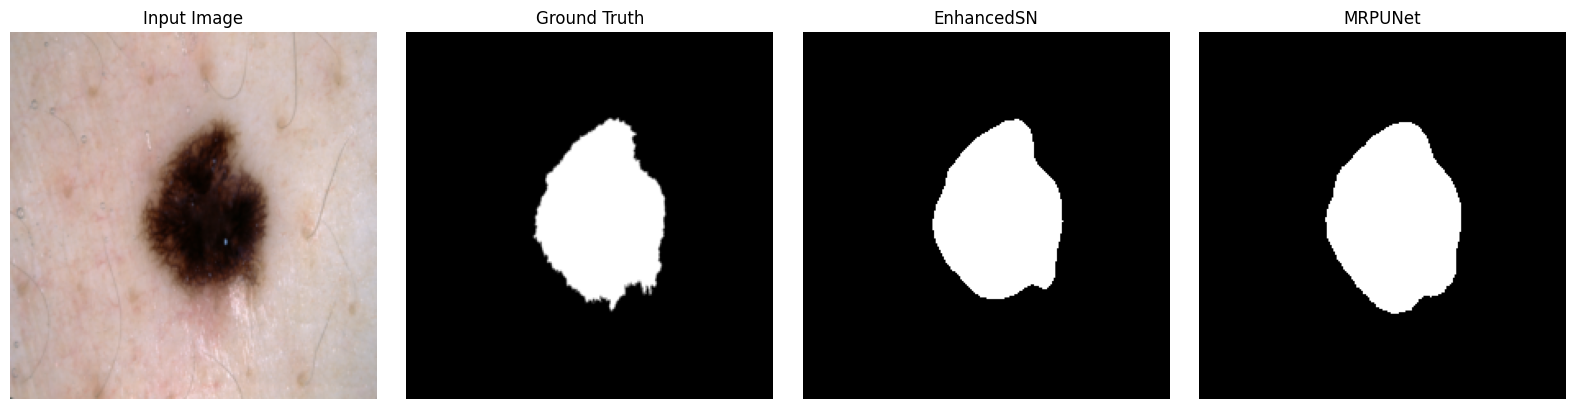


--- Sample 301 ---
Ground truth mean: 0.1920
EnhancedSN pred mean: 0.2062
MRPUNet pred mean: 0.2379
MRPUNet pred range: [0.0005, 1.0000]

 Metrics Comparison:
Metric          EnhancedSN   MRPUNet      Better    
-------------------------------------------------------
Dice            0.9627       0.9204       EnhancedSN
Iou             0.9281       0.8525       EnhancedSN
Pixel Accuracy  0.9765       0.9588       EnhancedSN

 Better Dice Score: EnhancedSN
   EnhancedSN: 0.9627
   MRPUNet: 0.9204
   Difference: 0.0423


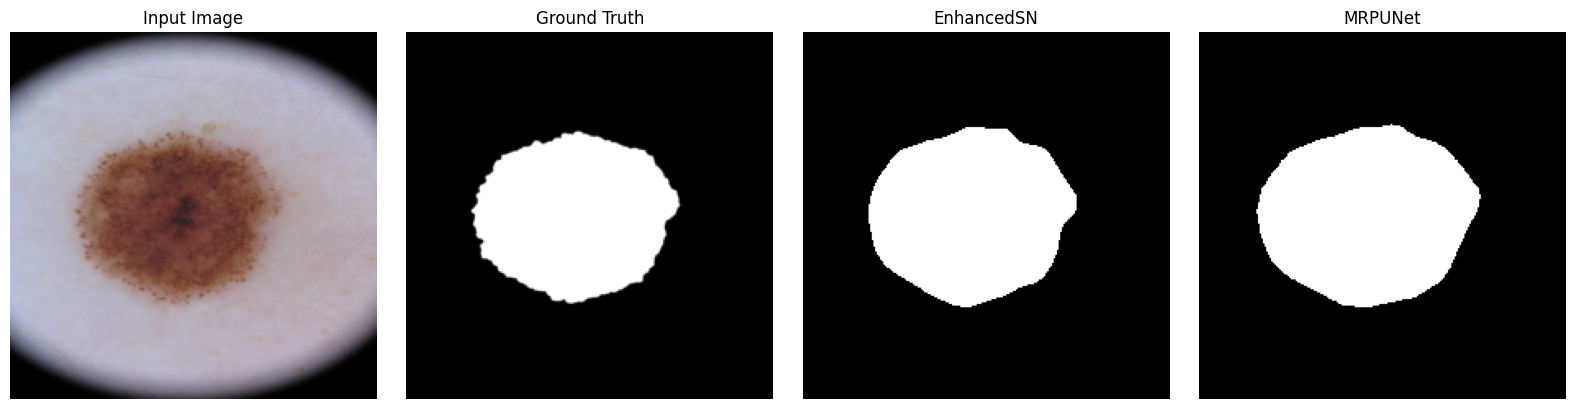


--- Sample 142 ---
Ground truth mean: 0.0527
EnhancedSN pred mean: 0.0531
MRPUNet pred mean: 0.0740
MRPUNet pred range: [0.0006, 1.0000]

 Metrics Comparison:
Metric          EnhancedSN   MRPUNet      Better    
-------------------------------------------------------
Dice            0.9777       0.9585       EnhancedSN
Iou             0.9564       0.9202       EnhancedSN
Pixel Accuracy  0.9921       0.9909       EnhancedSN

 Better Dice Score: EnhancedSN
   EnhancedSN: 0.9777
   MRPUNet: 0.9585
   Difference: 0.0192


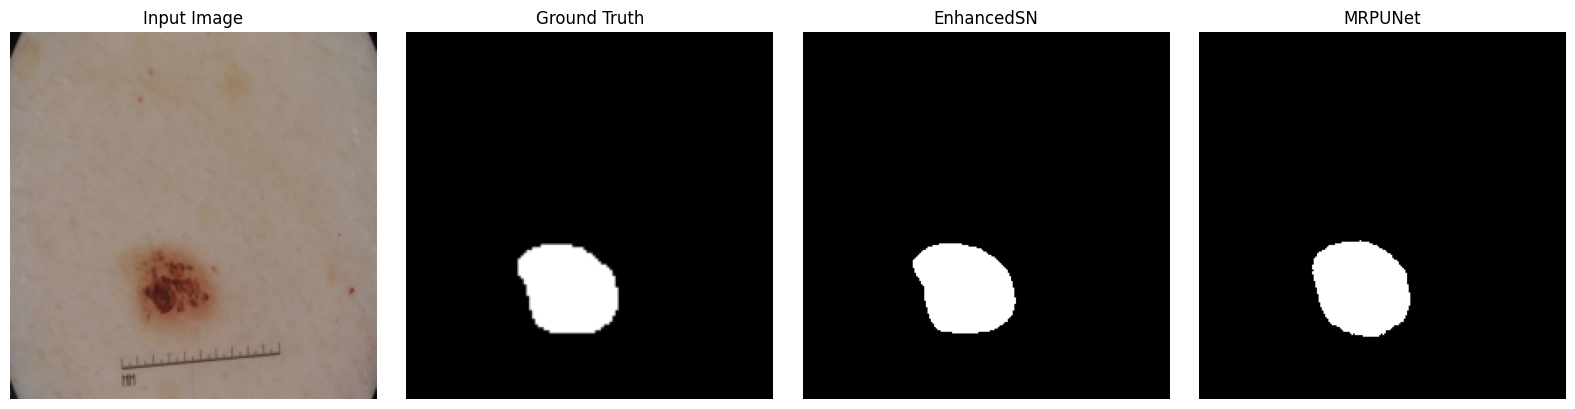


📈 Average Metrics Across All Samples:
Model        Dice     IoU      Pixel Acc 
----------------------------------------
EnhancedSN   0.9722   0.9460   0.9835    
MRPUNet      0.9404   0.8880   0.9752    

 Overall Winner (Dice): EnhancedSN
   EnhancedSN: 0.9722
   MRPUNet: 0.9404

 Model comparison completed with your MRPUNet architecture!

Key points about your MRPUNet:
- Has built-in sigmoid activation
- Outputs are interpolated to 224x224
- Uses multi-scale input features (MIF)
-  Has proper skip connections in decoder
-  Expects normalized input [-1, 1] range


In [63]:
# ---- Load Models with Your MRPUNet Architecture ----
import torch
import torch.nn as nn
import torch.nn.functional as F
from random import sample

# ========== Your MRPUNet Architecture ==========
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.fc1 = nn.Linear(in_channels, in_channels // reduction)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels)

    def forward(self, x):
        b, c, _, _ = x.size()
        y = F.adaptive_avg_pool2d(x, 1).view(b, c)
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).view(b, c, 1, 1)
        return x * y

class Res2Block(nn.Module):
    def __init__(self, channels, scale=4):
        super().__init__()
        self.scale = scale
        self.width = channels // scale
        self.conv_first = nn.Conv2d(channels, channels, kernel_size=1)
        self.convs = nn.ModuleList([nn.Sequential(
            nn.Conv2d(self.width, self.width, 3, padding=1),
            nn.BatchNorm2d(self.width, momentum=0.002),
            nn.ReLU(inplace=True)
        ) for _ in range(scale - 1)])
        self.conv_last = nn.Conv2d(channels, channels, kernel_size=1)
        self.bn_last = nn.BatchNorm2d(channels, momentum=0.002)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.conv_first(x)
        splits = torch.split(out, self.width, dim=1)
        outputs = [splits[0]]
        for i in range(1, self.scale):
            if i == 1:
                sp = splits[i]
            else:
                sp = splits[i] + outputs[i - 1]
            outputs.append(self.convs[i - 1](sp))
        out = torch.cat(outputs, dim=1)
        out = self.conv_last(out)
        out = self.bn_last(out)
        return self.relu(out)

class Res2SEBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.res2 = Res2Block(channels)
        self.se = SEBlock(channels)

    def forward(self, x):
        x = self.res2(x)
        x = self.se(x)
        return x

class PDCBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branch1 = nn.Conv2d(in_channels, out_channels, 3, padding=1, dilation=1)
        self.branch2 = nn.Conv2d(in_channels, out_channels, 3, padding=2, dilation=2)
        self.branch3 = nn.Conv2d(in_channels, out_channels, 3, padding=3, dilation=3)
        self.branch4 = nn.Conv2d(in_channels, out_channels, 3, padding=4, dilation=4)
        self.fuse = nn.Conv2d(out_channels * 4, out_channels, 1)

    def forward(self, x):
        b1 = self.branch1(x)
        b2 = self.branch2(x)
        b3 = self.branch3(x)
        b4 = self.branch4(x)
        out = torch.cat([b1, b2, b3, b4], dim=1)
        return self.fuse(out)

class MIFModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 1)
        self.conv2 = nn.Conv2d(3, 128, 1)
        self.conv3 = nn.Conv2d(3, 256, 1)
        self.conv4 = nn.Conv2d(3, 512, 1)

    def forward(self, x):
        s1 = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=True)
        s2 = F.interpolate(x, size=(112, 112), mode='bilinear', align_corners=True)
        s3 = F.interpolate(x, size=(56, 56), mode='bilinear', align_corners=True)
        s4 = F.interpolate(x, size=(28, 28), mode='bilinear', align_corners=True)
        s1 = self.conv1(s1)
        s2 = self.conv2(s2)
        s3 = self.conv3(s3)
        s4 = self.conv4(s4)
        return s1, s2, s3, s4

class MRPUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.mif = MIFModule()
        self.enc1 = Res2SEBlock(64)
        self.enc2 = Res2SEBlock(128)
        self.enc3 = Res2SEBlock(256)
        self.enc4 = Res2SEBlock(512)
        self.proj2 = nn.Conv2d(64, 128, kernel_size=1)
        self.proj3 = nn.Conv2d(128, 256, kernel_size=1)
        self.proj4 = nn.Conv2d(256, 512, kernel_size=1)
        self.pool = nn.MaxPool2d(2)
        self.pdc = PDCBlock(512, 1024)
        self.up3 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec3 = Res2SEBlock(512)
        self.up2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec2 = Res2SEBlock(256)
        self.up1 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec1 = Res2SEBlock(128)
        self.final = nn.Conv2d(128, 1, 1)

    def forward(self, x):
        s1, s2, s3, s4 = self.mif(x)
        e1 = self.enc1(s1)
        e2 = self.enc2(self.proj2(self.pool(e1)) + s2)
        e3 = self.enc3(self.proj3(self.pool(e2)) + s3)
        e4 = self.enc4(self.proj4(self.pool(e3)) + s4)
        b = self.pdc(self.pool(e4))
        d3 = self.dec3(self.up3(b) + e4)
        d2 = self.dec2(self.up2(d3) + e3)
        d1 = self.dec1(self.up1(d2) + e2)
        out = self.final(d1)
        out = torch.sigmoid(out)
        out = F.interpolate(out, size=(224, 224), mode='bilinear', align_corners=True)
        return out

# ========== Device Setup ==========
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ========== Load EnhancedSN ==========
try:
    enhanced_sn = EnhancedSN().to(device)
    enhanced_sn.load_state_dict(torch.load("best_enhanced_sn.pth", map_location=device))
    enhanced_sn.eval()
    print("✓ EnhancedSN loaded successfully!")
except Exception as e:
    print(f"✗ Error loading EnhancedSN: {e}")
    enhanced_sn = None

# ========== Load Your MRPUNet ==========
try:
    print("Loading MRPUNet model...")
    mrp_unet = MRPUNet().to(device)
    
    # Load your saved state dict
    checkpoint_path = "/kaggle/input/mrpunet_base/pytorch/default/1/best_mrp_unet.pth"
    state_dict = torch.load(checkpoint_path, map_location=device)
    
    # Load with error handling
    missing_keys, unexpected_keys = mrp_unet.load_state_dict(state_dict, strict=False)
    
    if missing_keys:
        print(f"Warning - Missing keys: {missing_keys}")
    if unexpected_keys:
        print(f"Warning - Unexpected keys: {unexpected_keys}")
    
    mrp_unet.eval()
    print("✓ MRPUNet loaded successfully!")
    
    # Test the model with a dummy input
    with torch.no_grad():
        dummy_rgb = torch.randn(1, 3, 224, 224).to(device)
        test_output = mrp_unet(dummy_rgb)
        print(f"✓ MRPUNet test successful - Output shape: {test_output.shape}")
        print(f"✓ Output range: [{test_output.min().item():.4f}, {test_output.max().item():.4f}]")
        print(f"✓ Output mean: {test_output.mean().item():.4f}")
    
except Exception as e:
    print(f"✗ Error loading MRPUNet: {e}")
    print("Creating new MRPUNet instance...")
    mrp_unet = MRPUNet().to(device)
    mrp_unet.eval()

# ========== Normalization Function ==========
def normalize_rgb_for_mrpunet(rgb_tensor):
    """
    Normalize RGB tensor to [-1, 1] range as expected by MRPUNet
    Input: rgb_tensor with values in [0, 1] range
    Output: normalized tensor with values in [-1, 1] range
    """
    return (rgb_tensor - 0.5) / 0.5

# ========== Dice Score Calculation ==========
def dice_score(pred, target, threshold=0.5, smooth=1e-6):
    """
    Calculate Dice Score (F1 Score for binary segmentation)
    Args:
        pred: Predicted mask (values between 0 and 1)
        target: Ground truth mask (binary: 0 or 1)
        threshold: Threshold to binarize predictions
        smooth: Smoothing factor to avoid division by zero
    Returns:
        Dice score (float)
    """
    # Binarize prediction
    pred_binary = (pred > threshold).float()
    target_binary = target.float()
    
    # Calculate intersection and union
    intersection = (pred_binary * target_binary).sum()
    total = pred_binary.sum() + target_binary.sum()
    
    # Calculate dice score
    dice = (2.0 * intersection + smooth) / (total + smooth)
    return dice.item()

def iou_score(pred, target, threshold=0.5, smooth=1e-6):
    """
    Calculate IoU Score (Intersection over Union)
    Args:
        pred: Predicted mask (values between 0 and 1)
        target: Ground truth mask (binary: 0 or 1)
        threshold: Threshold to binarize predictions
        smooth: Smoothing factor to avoid division by zero
    Returns:
        IoU score (float)
    """
    # Binarize prediction
    pred_binary = (pred > threshold).float()
    target_binary = target.float()
    
    # Calculate intersection and union
    intersection = (pred_binary * target_binary).sum()
    union = pred_binary.sum() + target_binary.sum() - intersection
    
    # Calculate IoU score
    iou = (intersection + smooth) / (union + smooth)
    return iou.item()

def pixel_accuracy(pred, target, threshold=0.5):
    """
    Calculate Pixel Accuracy
    Args:
        pred: Predicted mask (values between 0 and 1)
        target: Ground truth mask (binary: 0 or 1)
        threshold: Threshold to binarize predictions
    Returns:
        Pixel accuracy (float)
    """
    pred_binary = (pred > threshold).float()
    target_binary = target.float()
    
    correct = (pred_binary == target_binary).float().sum()
    total = target_binary.numel()
    
    return (correct / total).item()

def calculate_all_metrics(pred, target, threshold=0.5):
    """
    Calculate all metrics for a prediction
    """
    dice = dice_score(pred, target, threshold)
    iou = iou_score(pred, target, threshold)
    pixel_acc = pixel_accuracy(pred, target, threshold)
    
    return {
        'dice': dice,
        'iou': iou,
        'pixel_accuracy': pixel_acc
    }

def print_metrics_comparison(metrics1, metrics2, label1="Model 1", label2="Model 2"):
    """
    Print a nice comparison of metrics between two models
    """
    print(f"\n Metrics Comparison:")
    print(f"{'Metric':<15} {label1:<12} {label2:<12} {'Better':<10}")
    print("-" * 55)
    
    for metric in ['dice', 'iou', 'pixel_accuracy']:
        val1 = metrics1[metric]
        val2 = metrics2[metric]
        better = label1 if val1 > val2 else label2 if val2 > val1 else "Tie"
        
        print(f"{metric.replace('_', ' ').title():<15} {val1:<12.4f} {val2:<12.4f} {better:<10}")
    
    # Overall winner
    dice_winner = "EnhancedSN" if metrics1['dice'] > metrics2['dice'] else "MRPUNet"
    print(f"\n Better Dice Score: {dice_winner}")
    print(f"   EnhancedSN: {metrics1['dice']:.4f}")
    print(f"   MRPUNet: {metrics2['dice']:.4f}")
    print(f"   Difference: {abs(metrics1['dice'] - metrics2['dice']):.4f}")

def accumulate_metrics(all_metrics, new_metrics, model_name):
    """
    Accumulate metrics for averaging later
    """
    if model_name not in all_metrics:
        all_metrics[model_name] = {'dice': [], 'iou': [], 'pixel_accuracy': []}
    
    for metric in ['dice', 'iou', 'pixel_accuracy']:
        all_metrics[model_name][metric].append(new_metrics[metric])

def print_average_metrics(all_metrics):
    """
    Print average metrics across all samples
    """
    print(f"\n📈 Average Metrics Across All Samples:")
    print(f"{'Model':<12} {'Dice':<8} {'IoU':<8} {'Pixel Acc':<10}")
    print("-" * 40)
    
    avg_metrics = {}
    for model_name, metrics in all_metrics.items():
        avg_dice = sum(metrics['dice']) / len(metrics['dice'])
        avg_iou = sum(metrics['iou']) / len(metrics['iou'])
        avg_pixel_acc = sum(metrics['pixel_accuracy']) / len(metrics['pixel_accuracy'])
        
        avg_metrics[model_name] = {
            'dice': avg_dice,
            'iou': avg_iou,
            'pixel_accuracy': avg_pixel_acc
        }
        
        print(f"{model_name:<12} {avg_dice:<8.4f} {avg_iou:<8.4f} {avg_pixel_acc:<10.4f}")
    
    # Overall winner
    if len(avg_metrics) == 2:
        models = list(avg_metrics.keys())
        model1, model2 = models[0], models[1]
        
        dice_winner = model1 if avg_metrics[model1]['dice'] > avg_metrics[model2]['dice'] else model2
        print(f"\n Overall Winner (Dice): {dice_winner}")
        print(f"   {model1}: {avg_metrics[model1]['dice']:.4f}")
        print(f"   {model2}: {avg_metrics[model2]['dice']:.4f}")
    
    return avg_metrics

# ========== Get Samples for Comparison ==========
# Initialize metrics accumulator
all_metrics = {}

if 'val_dataset' not in locals():
    print("Warning: val_dataset not found. Please define your validation dataset.")
    print("Creating dummy samples for testing...")
    
    # Create dummy samples for testing
    sample_indices = [0, 1, 2]
    for idx in sample_indices:
        print(f"\n--- Testing with dummy sample {idx} ---")
        
        # Create dummy inputs
        dummy_4ch = torch.randn(1, 4, 224, 224).to(device)
        dummy_mask = torch.randint(0, 2, (1, 1, 224, 224)).float().to(device)
        
        image_rgb = dummy_4ch[0, :3]
        cam = dummy_4ch[:, 3:, :, :]
        
        try:
            with torch.no_grad():
                # Test EnhancedSN if available
                if enhanced_sn is not None:
                    pred1 = torch.sigmoid(enhanced_sn(dummy_4ch, cam))
                    print(f"✓ EnhancedSN prediction - Mean: {pred1.mean().item():.4f}")
                    
                    # Calculate metrics for EnhancedSN
                    metrics1 = calculate_all_metrics(pred1[0], dummy_mask[0])
                    accumulate_metrics(all_metrics, metrics1, "EnhancedSN")
                else:
                    pred1 = None
                    print("✗ EnhancedSN not available")
                
                # Test MRPUNet
                rgb_input = dummy_4ch[:, :3, :, :]
                # Normalize RGB input for MRPUNet (assuming it expects [-1, 1] range)
                rgb_normalized = normalize_rgb_for_mrpunet(rgb_input)
                
                pred2 = mrp_unet(rgb_normalized)  # MRPUNet already applies sigmoid internally
                print(f"✓ MRPUNet prediction - Mean: {pred2.mean().item():.4f}")
                print(f"  Range: [{pred2.min().item():.4f}, {pred2.max().item():.4f}]")
                
                # Calculate metrics for MRPUNet
                metrics2 = calculate_all_metrics(pred2[0], dummy_mask[0])
                accumulate_metrics(all_metrics, metrics2, "MRPUNet")
                
                # Print comparison if both models available
                if pred1 is not None:
                    print_metrics_comparison(metrics1, metrics2, "EnhancedSN", "MRPUNet")
                
        except Exception as e:
            print(f"✗ Error in prediction: {e}")
            continue

else:
    # Use real validation dataset
    sample_indices = sample(range(len(val_dataset)), 3)
    
    for idx in sample_indices:
        try:
            input_4ch, mask = val_dataset[idx]
            input_4ch = input_4ch.unsqueeze(0).to(device)  # [1, 4, 224, 224]
            mask = mask.unsqueeze(0).to(device)            # [1, 1, 224, 224]
            
            image_rgb = input_4ch[0, :3].detach()
            cam = input_4ch[:, 3:, :, :]
            
            print(f"\n--- Sample {idx} ---")
            print(f"Ground truth mean: {mask.mean().item():.4f}")
            
            with torch.no_grad():
                # Predict from EnhancedSN
                if enhanced_sn is not None:
                    pred1 = torch.sigmoid(enhanced_sn(input_4ch, cam))
                    print(f"EnhancedSN pred mean: {pred1.mean().item():.4f}")
                    
                    # Calculate metrics for EnhancedSN
                    metrics1 = calculate_all_metrics(pred1[0], mask[0])
                    accumulate_metrics(all_metrics, metrics1, "EnhancedSN")
                else:
                    pred1 = None
                    print("EnhancedSN not available")
                
                # Predict from MRPUNet using normalized RGB
                rgb_input = input_4ch[:, :3, :, :]
                rgb_normalized = normalize_rgb_for_mrpunet(rgb_input)
                
                pred2 = mrp_unet(rgb_normalized)  # Already sigmoid applied
                print(f"MRPUNet pred mean: {pred2.mean().item():.4f}")
                print(f"MRPUNet pred range: [{pred2.min().item():.4f}, {pred2.max().item():.4f}]")
                
                # Calculate metrics for MRPUNet
                metrics2 = calculate_all_metrics(pred2[0], mask[0])
                accumulate_metrics(all_metrics, metrics2, "MRPUNet")
                
                # Print comparison for this sample
                if pred1 is not None:
                    print_metrics_comparison(metrics1, metrics2, "EnhancedSN", "MRPUNet")
            
            # Visualize if compare_predictions function exists
            if 'compare_predictions' in locals() or 'compare_predictions' in globals():
                pred1_vis = pred1[0] if pred1 is not None else torch.zeros_like(mask[0])
                compare_predictions(
                    image_tensor=image_rgb,
                    mask_gt=mask[0],
                    pred1=pred1_vis,
                    pred2=pred2[0],
                    label1="EnhancedSN",
                    label2="MRPUNet"
                )
            else:
                print("✓ Predictions generated successfully!")
                if pred1 is not None:
                    print(f"  EnhancedSN output shape: {pred1.shape}")
                print(f"  MRPUNet output shape: {pred2.shape}")
                
        except Exception as e:
            print(f"✗ Error processing sample {idx}: {e}")
            import traceback
            traceback.print_exc()
            continue

# Print overall average metrics
if all_metrics:
    avg_metrics = print_average_metrics(all_metrics)

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print("\n Model comparison completed with your MRPUNet architecture!")
print("\nKey points about your MRPUNet:")
print("- Has built-in sigmoid activation")
print("- Outputs are interpolated to 224x224")
print("- Uses multi-scale input features (MIF)")
print("-  Has proper skip connections in decoder")
print("-  Expects normalized input [-1, 1] range")